# Overlapping speech 

In [1]:
from notebook_utils import (
    load_files_to_df,
    expand_abbreviations,
    make_plot,
)
from asr_eval import utils
from pathlib import Path
import pandas as pd


pd.options.mode.copy_on_write = True

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.

Importing the aligned_semantic_distance module. When using in academic works please cite:
  Janine Rugayan and Torbjørn Svendsen and Giampiero Salvi (2022). Semantically Meaningful Metrics for Norwegian ASR Systems. In Interspeech, pp. 2283-2287, doi:10.21437/Interspeech.2022-817.



/home/tita/koding/asr_eval/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
p_current = Path("../data/output/2024")

df = load_files_to_df(p_current)
df = expand_abbreviations(df)

In [3]:
def recreate_audiofilepath(segmented_audio_path: str) -> str:
    # new_str = segmented_audio_path.replace("segmented/", "")
    new_str, _, end_time = segmented_audio_path.rpartition("_")
    new_str, _, start_time = new_str.rpartition("_")
    return new_str


df["audiofile"] = df["segmented_audio"].apply(recreate_audiofilepath)


In [ ]:
dfs = []
for (filename, model, lang, lang_pred), df_ in df.groupby(
    ["audiofile", "model_name", "language_code", "prediction_langcode"]
):
    if lang != lang_pred:
        print(
            f"""filename:\t{filename}\nmodel\t\t{model}\nlang\t\t{lang}\npred lang:\t{lang_pred}\n"""
        )
    df_ = df_.copy()
    df_.index = range(len(df_))
    df_.sort_values(["start_ms"], inplace=True)

    df_["start_s"] = round(df_["start_ms"] / 1000, 0)
    df_["end_s"] = round(df_["end_ms"] / 1000, 0)

    # Two segments are overlapping if one starts before the other ends or ends after the other starts
    df_["overlapping"] = (df_["start_s"] < df_["end_s"].shift(1)) | (
        df_["end_s"] > df_["start_s"].shift(-1)
    )
    dfs.append(df_)


df = pd.concat(dfs, ignore_index=True)
mean_score_file = Path("../data/output/2024/mean_scores_overlapping.csv")
if not mean_score_file.exists():
    mean_score_df = utils.calculate_mean_scores(df, "overlapping")
    mean_score_df.to_csv(mean_score_file, index=False)
else:
    mean_score_df = pd.read_csv(mean_score_file)

In [5]:
mean_score_df

,modell,språk,CER,WER,aligned semantic distance,semantic distance,semantic distance (sBERT),overlapping
0,azure,nob,0.149062,0.231494,0.247688,0.077160,0.126159,False
1,azure,nob,0.225041,0.337189,0.462946,0.159781,0.242648,True
2,chirp,nob,0.111318,0.190397,0.259847,0.096039,0.139372,False
3,chirp,nob,0.246211,0.324395,0.452990,0.196292,0.271336,True
4,chirp_2,nob,0.111113,0.190364,0.261687,0.097065,0.140406,False
5,chirp_2,nob,0.245174,0.323169,0.450818,0.195412,0.270198,True
6,facebook_mms-1b-all,nno,0.275372,0.667325,0.869546,0.290690,0.385003,False
7,facebook_mms-1b-all,nno,0.394631,0.756286,0.959206,0.378553,0.485207,True
8,facebook_mms-1b-all,nob,0.231287,0.584139,0.859961,0.272933,0.374542,False
9,facebook_mms-1b-all,nob,0.359523,0.691991,0.959998,0.368606,0.479365,True


In [6]:
df.overlapping.value_counts()

overlapping
False    99632
True     16528
Name: count, dtype: int64

In [7]:
imagedir = Path("images")
imagedir.mkdir(exist_ok=True)

## Heatmap

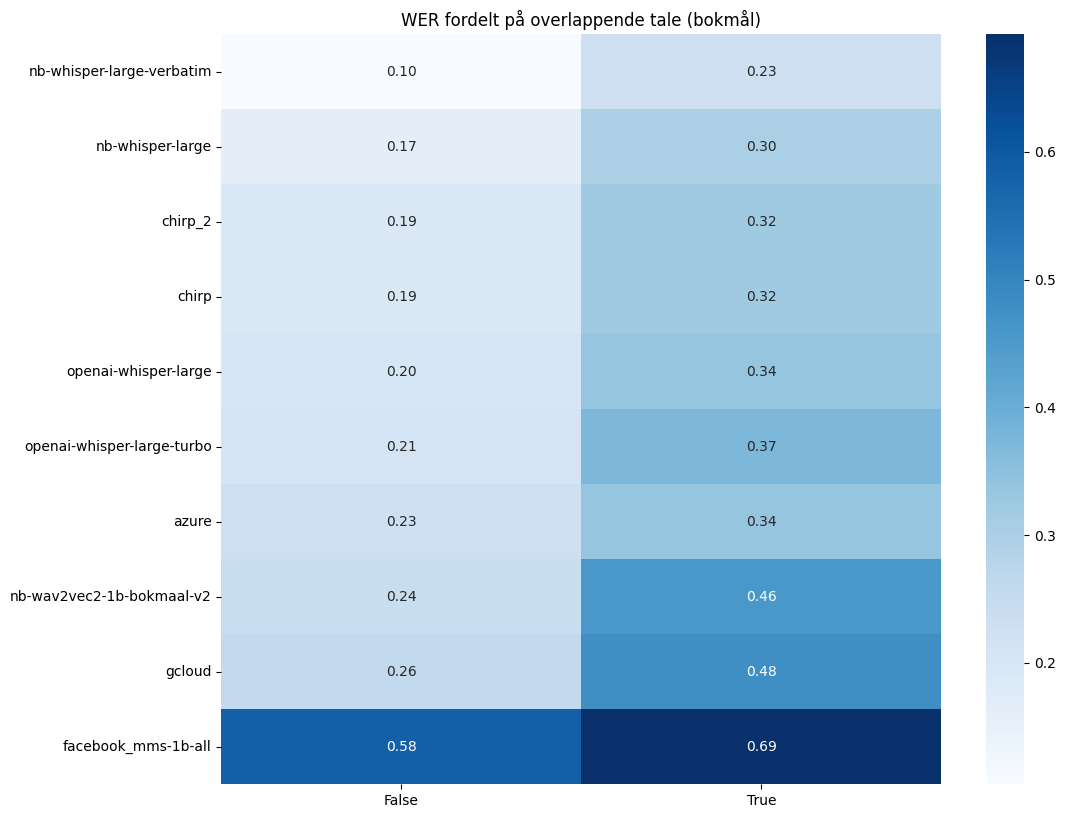

In [8]:
make_plot(
    mean_score_df,
    plot_type="heatmap",
    feature="overlapping",
    metric="WER",
    language="nob",
    save_to_dir=imagedir,
)

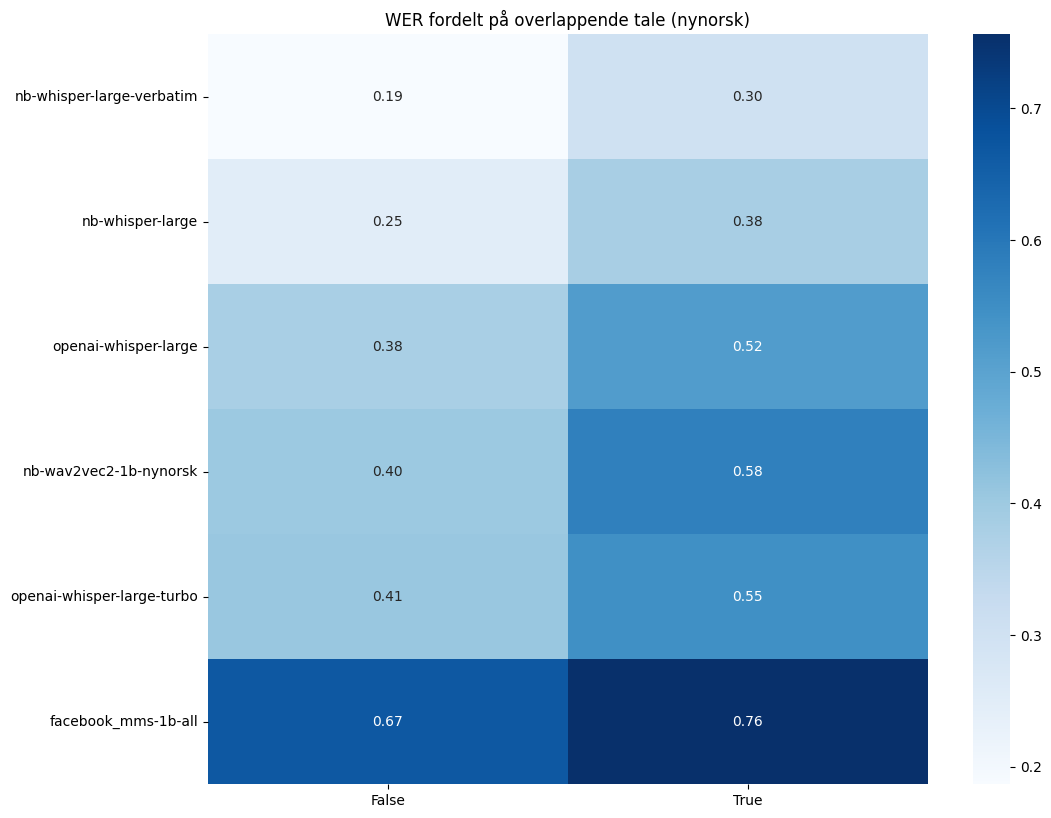

In [9]:
make_plot(
    mean_score_df,
    plot_type="heatmap",
    feature="overlapping",
    metric="WER",
    language="nno",
    save_to_dir=imagedir,
)

## Barchart

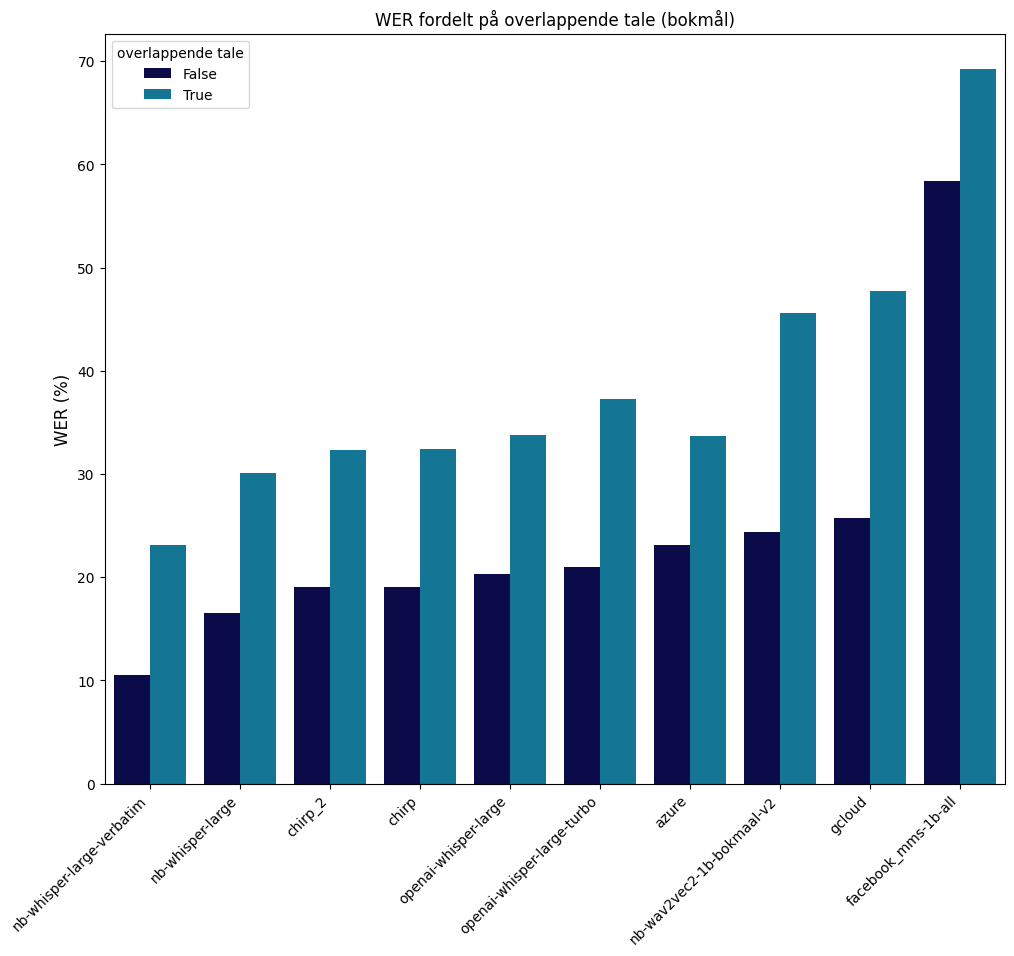

In [10]:
make_plot(
    mean_score_df,
    plot_type="barchart",
    feature="overlapping",
    metric="WER",
    language="nob",
    save_to_dir=imagedir,
)

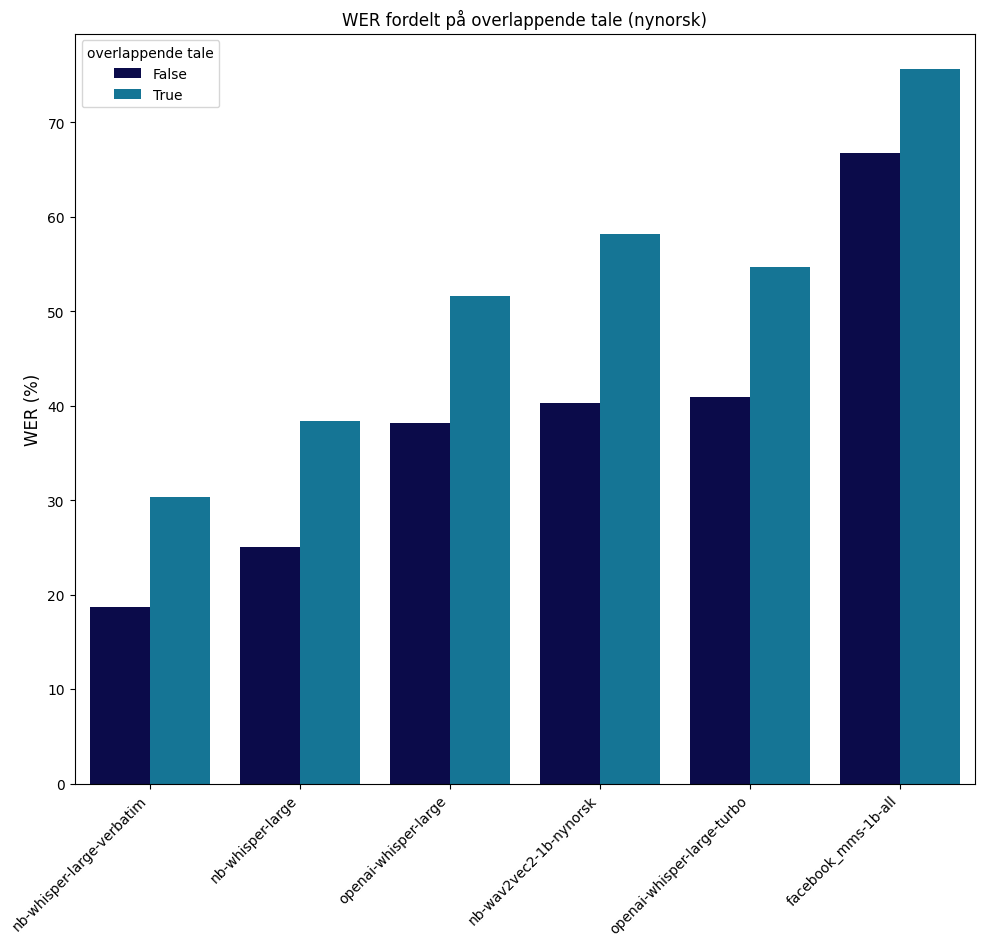

In [11]:
make_plot(
    mean_score_df,
    plot_type="barchart",
    feature="overlapping",
    metric="WER",
    language="nno",
    save_to_dir=imagedir,
)